In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\Antho\AppData\Local\Temp\ipykernel_16052\1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)


2017-08-23


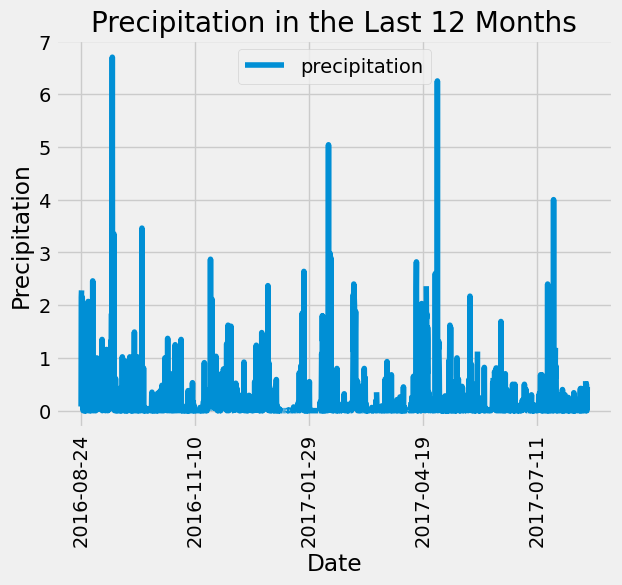

In [10]:
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation in the Last 12 Months")
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)


       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Get the most active station id
most_active_station_id = most_active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


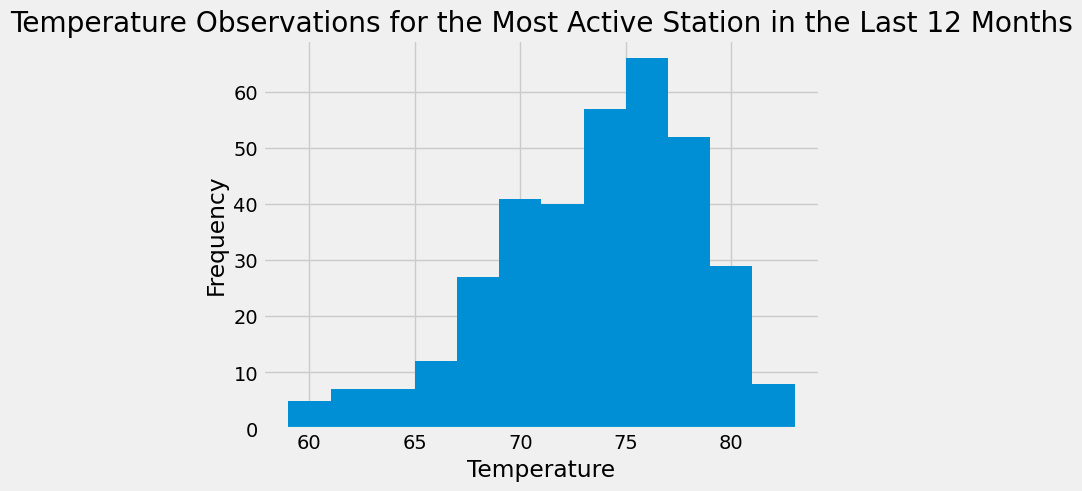

In [15]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Plot the results as a histogram
temperature_df['temperature'].plot(kind='hist', bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Observations for the Most Active Station in the Last 12 Months")
plt.show()


# Close Session

In [16]:
# Close Session
session.close()

In [17]:
pip install Flask sqlalchemy


Note: you may need to restart the kernel to use updated packages.


In [18]:
from flask import Flask, jsonify
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import datetime as dt


In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

C:\Users\Antho\AppData\Local\Temp\ipykernel_16052\1898827671.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [20]:
Measurement = Base.classes.measurement
Station = Base.classes.station


In [21]:
app = Flask(__name__)

In [22]:
@app.route("/")
def welcome():
    return (
        f"Welcome to the Climate API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end><br/>"
    )

In [23]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    session = Session(engine)
    # Get date one year ago from the latest date in the data
    latest_date = session.query(func.max(Measurement.date)).scalar()
    one_year_ago = (dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)).date()


In [26]:
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
session.close()

In [ ]:
precipitation_data = {date: prcp for date, prcp in results}
return jsonify(precipitation_data)


In [29]:
@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    results = session.query(Station.station).all()
    session.close()

    # Convert list of tuples to a flat list
    station_list = [station[0] for station in results]
    return jsonify(station_list)


In [30]:
@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)

In [31]:
most_active_station = session.query(Measurement.station, func.count(Measurement.id)) \
                                 .group_by(Measurement.station) \
                                 .order_by(func.count(Measurement.id).desc()) \
                                 .first()[0]

latest_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)).date()

In [32]:
results = session.query(Measurement.date, Measurement.tobs) \
                     .filter(Measurement.station == most_active_station) \
                     .filter(Measurement.date >= one_year_ago) \
                     .all()
session.close()

In [ ]:
tobs_data = [{date: tobs} for date, tobs in results]
return jsonify(tobs_data)

In [34]:
@app.route("/api/v1.0/<start>")
@app.route("/api/v1.0/<start>/<end>")
def temperature_range(start, end=None):
    session = Session(engine)

In [37]:
def temperature_range(start, end=None):
    session = Session(engine)
    if end:
        results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)) \
                         .filter(Measurement.date >= start) \
                         .filter(Measurement.date <= end) \
                         .all()
    else:
        results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)) \
                         .filter(Measurement.date >= start) \
                         .all()

    session.close()
    return results

In [ ]:
temperature_data = {
        "TMIN": results[0][0],
        "TAVG": results[0][1],
        "TMAX": results[0][2]
    }

return jsonify(temperature_data)

In [ ]:
if __name__ == "__main__":
    app.run(debug=True)
    
    session.close()